In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa

import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

print('TensorFlow Version ' + tf.__version__)
print("Python Version:", tf.__version__)
# print("Keras Version:", tf.keras.__version__)
print("CuDNN Version:", tf.sysconfig.get_build_info())
print("CUDA Version:", tf.sysconfig.get_build_info())


# tf.compat.v1.disable_eager_execution()


def seed_everything(seed = 1):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()




2024-10-22 19:55:25.129722: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 19:55:25.130046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 19:55:25.163231: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 19:55:25.266007: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-22 19:55:26.435210: W tensorflow/compiler/tf2

TensorFlow Version 2.15.0
Python Version: 2.15.0
CuDNN Version: OrderedDict([('cpu_compiler', '/usr/lib/llvm-17/bin/clang'), ('cuda_compute_capabilities', ['sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '12.2'), ('cudnn_version', '8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', True)])
CUDA Version: OrderedDict([('cpu_compiler', '/usr/lib/llvm-17/bin/clang'), ('cuda_compute_capabilities', ['sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '12.2'), ('cudnn_version', '8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', True)])


In [2]:
import tensorflow.keras.backend as K

K.clear_session()

In [3]:
# import tensorflow as tf
gpu_id = '0'  # or '0,1' for multiple GPUs

# Set GPU device
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.set_visible_devices(physical_devices[int(gpu_id)], 'GPU')
    # Optionally, you can set memory growth to avoid allocating all GPU memory at once
    tf.config.experimental.set_memory_growth(physical_devices[int(gpu_id)], True)
else:
    print("No GPU devices found.")

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


2024-10-22 19:55:28.617467: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-22 19:55:28.617710: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-22 19:55:29.064914: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-22 19:55:29.065016: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-22 19:55:29.065072: I external/local_xla/xla/stream_executor

In [4]:
image_size = 384
batch_size = 8
n_classes = 10
EPOCHS = 50

train_path = '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Balanced/Train'
# val_path = '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Balanced/Val' # combined in training


classes = {0 : "Pure Ocean Waves",
           1 : "Wind Streaks",
           2 : "Micro Convective Cells",
           3 : "Rain Cells",
           4 : "Biological Slicks",
           5 : "Sea Ice",
           6 : "Icebergs",
           7 : "Low Wind Area",
           8 : "Atmospheric Front",
           9 : "Oceanic Front",
           }




Data Augmentations

In [5]:
def data_augment(image):
    seed_everything()
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

Oversampling( future... now just manually removed some data and make them balanced,)

In [6]:

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.3,
                                                          preprocessing_function = None,
                                                        #   preprocessing_function = data_augment,
                                                          )

# datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255,  # Rescale pixel values for neural network compatibility
#     samplewise_center=True,  # Center the data sample-wise (mean = 0)
#     samplewise_std_normalization=True,  # Normalize the data sample-wise (std = 1)
#     validation_split=0.3,  # Reserve 20% of the data for validation
#     # preprocessing_function=data_augment,  # Custom preprocessing/augmentation function
#     rotation_range=180,  # Randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.2,  # Randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
#     shear_range=0.1,  # Apply shearing transformations
#     zoom_range=0.2,  # Randomly zooming inside pictures
#     horizontal_flip=True,  # Randomly flip images horizontally
#     fill_mode='nearest'  # Strategy used for filling in newly created pixels
# )



# set as training data
train_gen  = datagen.flow_from_directory(
    train_path,
    target_size=(384, 384),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb',
    shuffle = True,
    class_mode='categorical',
    subset='training') 

# same directory as validation data

valid_gen  = datagen.flow_from_directory(
    train_path,
    target_size=(384, 384),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb',
    shuffle = False,
    class_mode='categorical',
    subset='validation')



Found 4900 images belonging to 10 classes.
Found 2090 images belonging to 10 classes.


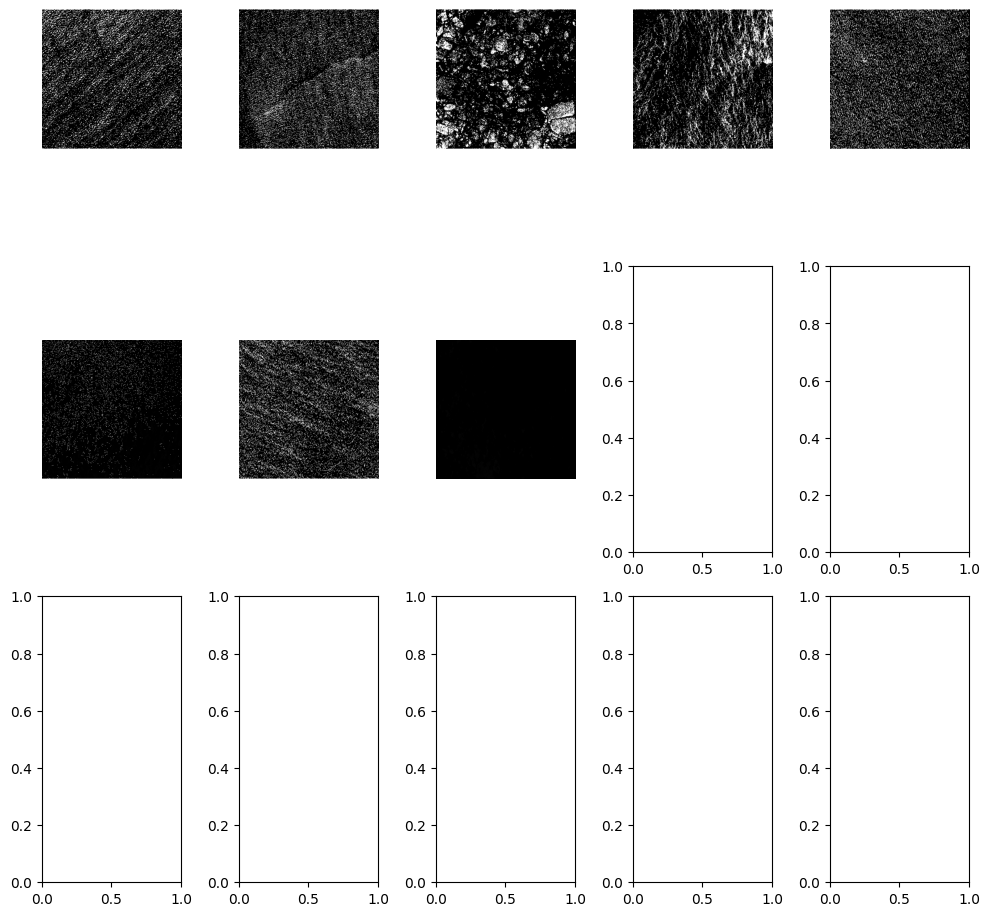

In [7]:
warnings.filterwarnings("ignore")

images = [train_gen[0][0][i] for i in range(8)]


fig, axes = plt.subplots(3, 5, figsize = (10, 10))

axes = axes.flatten()

for img, ax in zip(images, axes):
    ax.imshow(img.reshape(image_size, image_size, 3).astype("uint8"))
    ax.axis('off')

plt.tight_layout()
plt.show()

Build the Model

In [8]:
from vit_keras import vit,utils, visualize

# vit_model = vit.vit_b16(
#         image_size = image_size,
#         activation = 'softmax',
#         pretrained = True,
#         # include_top = False,
#         include_top = True,
#         pretrained_top = False,
#         classes = 10)

vit_model = vit.vit_l32(
    image_size=image_size,
    activation='sigmoid',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=10)


2024-10-22 19:55:31.881380: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-22 19:55:31.881492: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-22 19:55:31.881536: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-22 19:55:32.568488: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-22 19:55:32.568721: I external/local_xla/xla/stream_executor

Visualizing Attention Maps

In [9]:
# # warnings.filterwarnings("ignore")
# from vit_keras import vit,utils, visualize
# import matplotlib.pyplot as plt
# import numpy as np
# # Load a model
# image_size = 384
# classes = utils.get_imagenet_classes()
# model = vit.vit_b16(
#     image_size=image_size,
#     activation='sigmoid',
#     pretrained=True,
#     include_top=True,
#     pretrained_top=True
# )
# classes = utils.get_imagenet_classes()

# # Get an image and compute the attention map
# # url = 'https://upload.wikimedia.org/wikipedia/commons/b/bc/Free%21_%283987584939%29.jpg'
# # image = utils.read(url, image_size)
# path = './PNG/O/s1a-wv1-slc-vv-20160102t223009-20160102t223012-009321-00d78c-017.png'
# image = utils.read(path, image_size)
# attention_map = visualize.attention_map(model=model, image=image)
# print('Prediction:', classes[
#     model.predict(vit.preprocess_inputs(image)[np.newaxis])[0].argmax()]
# )  # Prediction: Eskimo dog, husky

# # Plot results
# fig, (ax1, ax2) = plt.subplots(ncols=2)
# ax1.axis('off')
# ax2.axis('off')
# ax1.set_title('Original')
# ax2.set_title('Attention Map')
# _ = ax1.imshow(image)
# _ = ax2.imshow(attention_map)

In [10]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 384 X 384
Patch size: 128 X 128
Patches per image: 9
Elements per patch: 49152


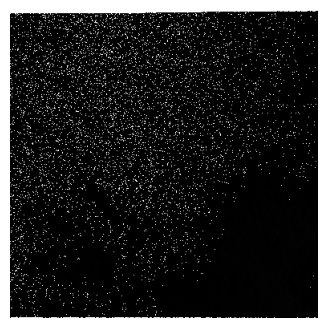

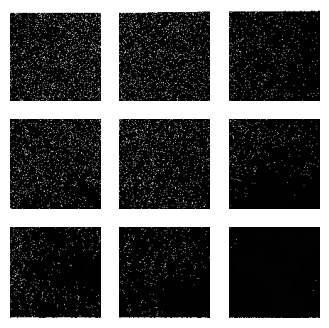

In [11]:
plt.figure(figsize=(4, 4))
batch_size = 8
patch_size = 128  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2

x = train_gen.next()
image = x[0][0]

plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

In [12]:
# class_frequencies = [4900, 4797, 4598, 4740, 4709, 4370, 1980, 2160, 4100, 1199]
# total_data_points = np.sum(class_frequencies)
# initial_biases = [np.log(total_data_points / freq) for freq in class_frequencies]
# initial_bias = tf.constant(initial_biases, dtype=tf.float32)
# custom_bias_initializer = tf.keras.initializers.Constant(initial_bias)

# model = tf.keras.Sequential([
#         vit_model,
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(128, activation = tfa.activations.gelu),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(64, activation = tfa.activations.gelu),
#         tf.keras.layers.Dense(32, activation = tfa.activations.gelu),
#         tf.keras.layers.Dense(10, 'softmax')
#     ],
#     name = 'vision_transformer')

model = vit_model

model.summary()

Model: "vit-l32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 12, 12, 1024)      3146752   
                                                                 
 reshape (Reshape)           (None, 144, 1024)         0         
                                                                 
 class_token (ClassToken)    (None, 145, 1024)         1024      
                                                                 
 Transformer/posembed_input  (None, 145, 1024)         148480    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 145, 1024),       12596224  
  (TransformerBlock)          (None, 16, None, None)       

In [13]:
warnings.filterwarnings("ignore")

learning_rate = 1e-4

# class_weight = { 
#     0: 4900/4900,
#     1: 4900/4797,
#     2: 4900/4598,
#     3: 4900/4740,
#     4: 4900/4709,
#     5: 4900/4370,
#     6: 4900/1980,
#     7: 4900/2160,
#     8: 4900/4100,
#     9: 4900/1199,
# }


optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size

checkpoint_path = "./checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True, verbose = 1)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_dir,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


history = model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = early_stopping_callbacks)

Epoch 1/50


2024-10-22 19:56:29.238354: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


612/612 [==============================] - 463s 649ms/step - loss: 1.1517 - accuracy: 0.8888 - val_loss: 1.0644 - val_accuracy: 0.9109
Epoch 2/50
612/612 [==============================] - 402s 657ms/step - loss: 0.9633 - accuracy: 0.9667 - val_loss: 0.9891 - val_accuracy: 0.9440
Epoch 3/50
612/612 [==============================] - 645s 1s/step - loss: 0.9363 - accuracy: 0.9761 - val_loss: 0.9587 - val_accuracy: 0.9593
Epoch 4/50
612/612 [==============================] - 700s 1s/step - loss: 0.9308 - accuracy: 0.9751 - val_loss: 1.0038 - val_accuracy: 0.9301
Epoch 5/50
612/612 [==============================] - 727s 1s/step - loss: 0.9526 - accuracy: 0.9634 - val_loss: 1.2194 - val_accuracy: 0.8443
Epoch 6/50
612/612 [==============================] - 732s 1s/step - loss: 0.9963 - accuracy: 0.9495 - val_loss: 0.9543 - val_accuracy: 0.9588
Epoch 7/50
612/612 [==============================] - 715s 1s/step - loss: 0.9059 - accuracy: 0.9873 - val_loss: 0.9730 - val_accuracy: 0.9497
Epoc

In [14]:
# checkpoint_path = "checkpoints/cp-{epoch:04d}.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# os.listdir(checkpoint_dir)

import pickle
class History_trained_model(object):
    def __init__(self, history, epoch, params):
        self.history = history
        self.epoch = epoch
        self.params = params

with open('/mnt/e/Projects/SAR_Training/Ten_events_classification/'+'/OViTmodel_noAugmentation_l32_384_T7V3_699_history', 'wb') as file:
    model_history= History_trained_model(history.history, history.epoch, history.params)
    pickle.dump(model_history, file, pickle.HIGHEST_PROTOCOL)

# with open(savemodel_path+'/history', 'rb') as file:
#     history=pickle.load(file)

# print(history.history)

model.save('/mnt/e/Projects/SAR_Training/Ten_events_classification/OViTmodel_noAugmentation_l32_384_T7V3_699.keras')

ViT Model Result

In [15]:
test_path = '/mnt/e/Projects/SAR_Training/Ten_events_classification/Data/Balanced/Test'

# testdatagen = tf.keras.preprocessing.image.ImageDataGenerator(
#     rescale=1./255  # Rescale pixel values for neural network compatibility
#     # samplewise_center=True,  # Center the data sample-wise (mean = 0)
#     # samplewise_std_normalization=True,  # Normalize the data sample-wise (std = 1)
#     # validation_split=0.2,  # Reserve 20% of the data for validation
#     # # preprocessing_function=data_augment,  # Custom preprocessing/augmentation function
#     # rotation_range=180,  # Randomly rotate images in the range (degrees, 0 to 180)
#     # width_shift_range=0.2,  # Randomly shift images horizontally (fraction of total width)
#     # height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
#     # shear_range=0.2,  # Apply shearing transformations
#     # zoom_range=0.2,  # Randomly zooming inside pictures
#     # horizontal_flip=True,  # Randomly flip images horizontally
#     # fill_mode='nearest'  # Strategy used for filling in newly created pixels
# )

test_gen  = datagen.flow_from_directory(
    test_path ,
    target_size=(384, 384),
    batch_size = 1,
    seed = 1,
    color_mode = 'rgb',
    shuffle = False,
    # class_mode='categorical',
    )

# test_gen  = testdatagen.flow_from_directory(
#     test_path ,
#     target_size=(384, 384),
#     batch_size = batch_size,
#     seed = 1,
#     color_mode = 'rgb',
#     shuffle = False,
#     # shuffle = True,
#     # class_mode='categorical',
#     )


Found 5000 images belonging to 10 classes.


5001/5001 [==============================] - 1702s 339ms/step


2024-10-22 22:18:35.022232: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5663922891768801068


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       500
           1       0.97      0.99      0.98       500
           2       0.96      0.99      0.97       500
           3       0.98      0.95      0.96       500
           4       0.98      0.96      0.97       500
           5       1.00      0.97      0.98       500
           6       0.97      0.93      0.95       500
           7       0.93      1.00      0.96       500
           8       0.96      0.95      0.95       500
           9       0.95      0.94      0.94       500

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



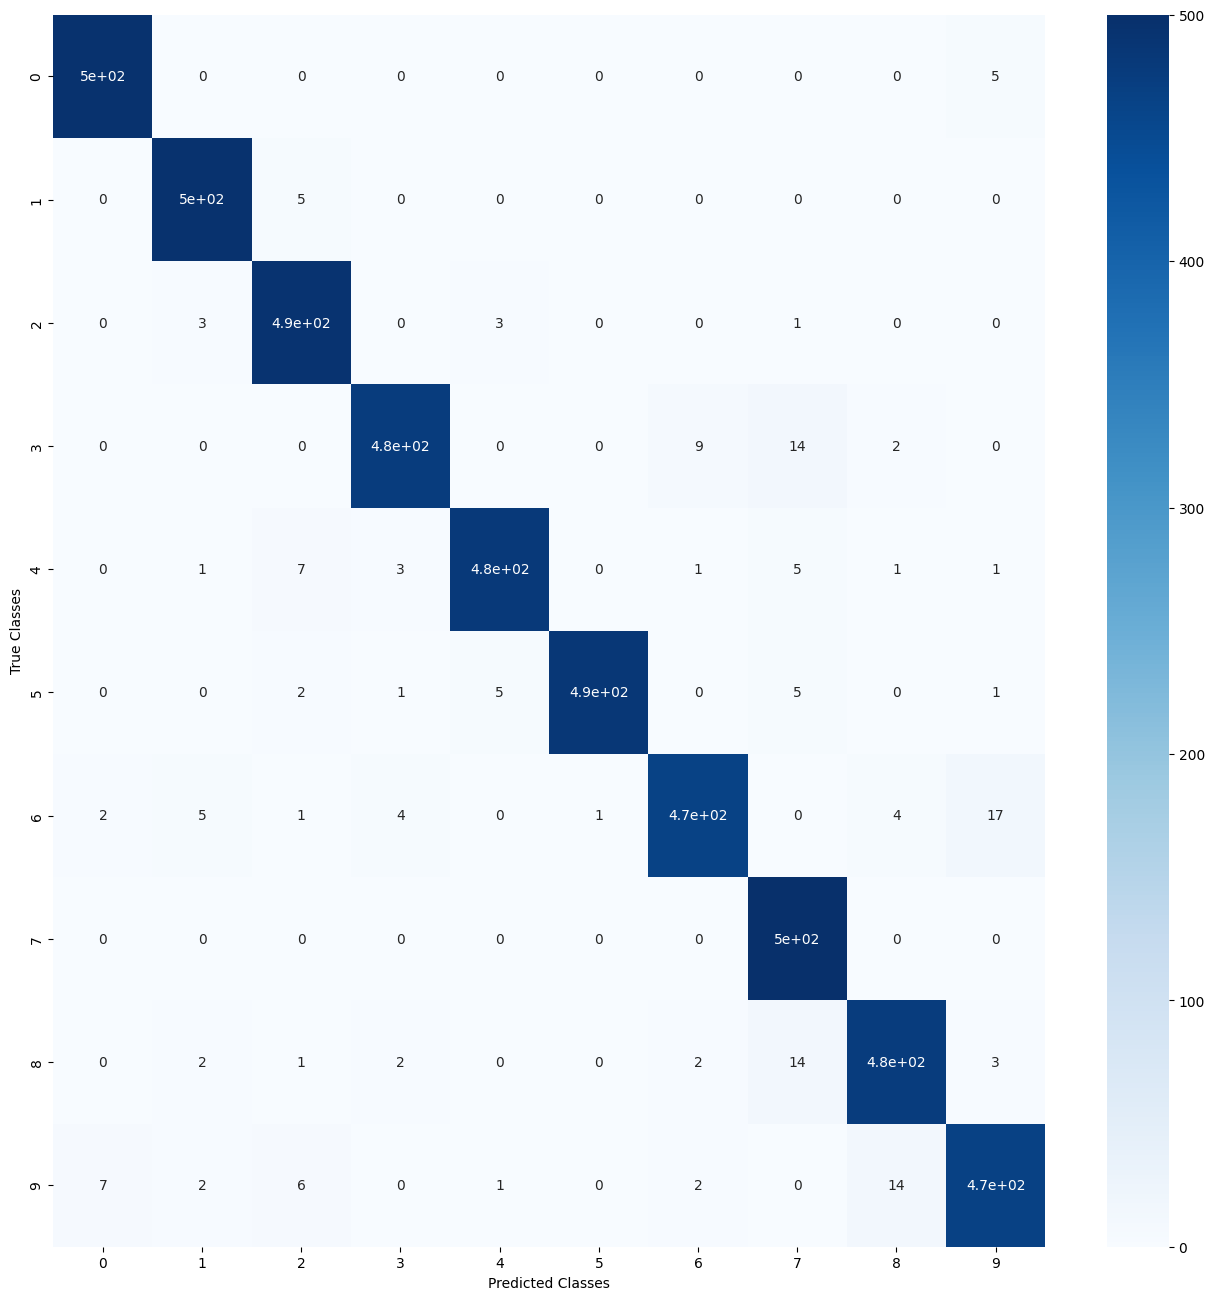

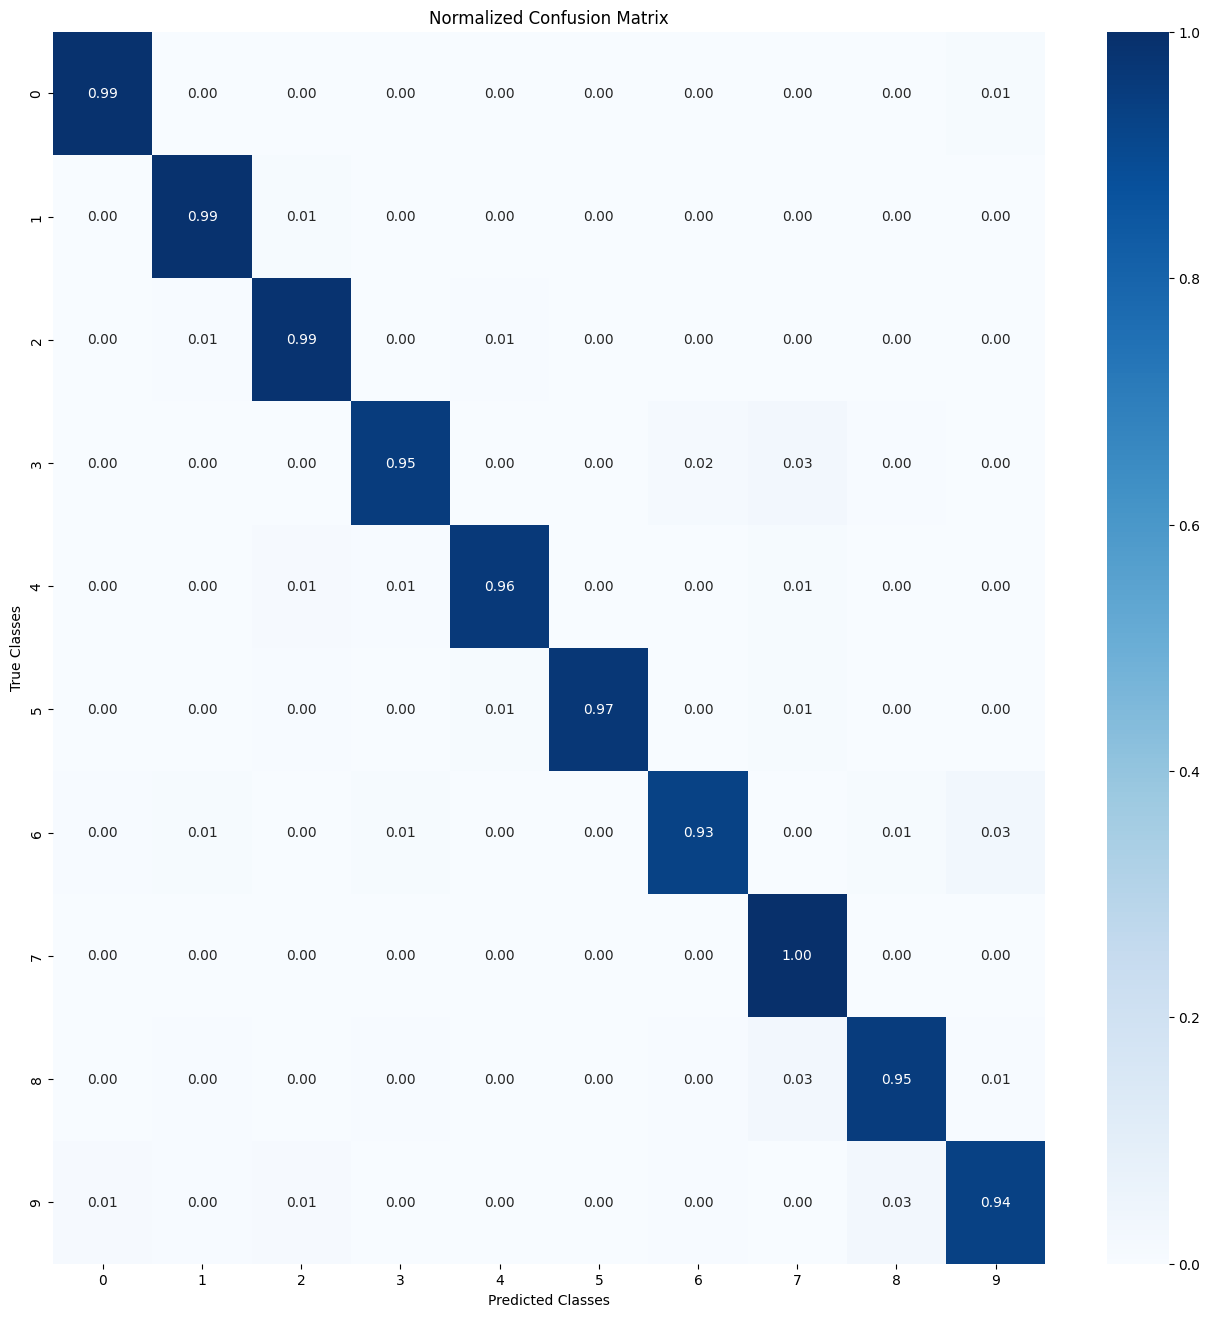

              precision    recall  f1-score   support

           F       0.98      0.99      0.99       500
           G       0.97      0.99      0.98       500
           H       0.96      0.99      0.97       500
           I       0.98      0.95      0.96       500
           J       0.98      0.96      0.97       500
           K       1.00      0.97      0.98       500
           L       0.97      0.93      0.95       500
           M       0.93      1.00      0.96       500
           N       0.96      0.95      0.95       500
           O       0.95      0.94      0.94       500

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



In [16]:
predicted_classes = np.argmax(model.predict(test_gen, steps = test_gen.n // test_gen.batch_size + 1), axis = 1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())  

confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')

print(classification_report(true_classes, predicted_classes))

# Normalize confusion matrix by row (i.e., by the number of true labels in each class)
normalized_confusionmatrix = confusionmatrix.astype('float') / confusionmatrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(16, 16))
sns.heatmap(normalized_confusionmatrix, cmap='Blues', annot=True, fmt=".2f", cbar=True)
plt.title('Normalized Confusion Matrix')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.show()
# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       500
           1       0.97      0.99      0.98       500
           2       0.96      0.99      0.97       500
           3       0.98      0.95      0.96       500
           4       0.98      0.96      0.97       500
           5       1.00      0.97      0.98       500
           6       0.97      0.93      0.95       500
           7       0.93      1.00      0.96       500
           8       0.96      0.95      0.95       500
           9       0.95      0.94      0.94       500

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



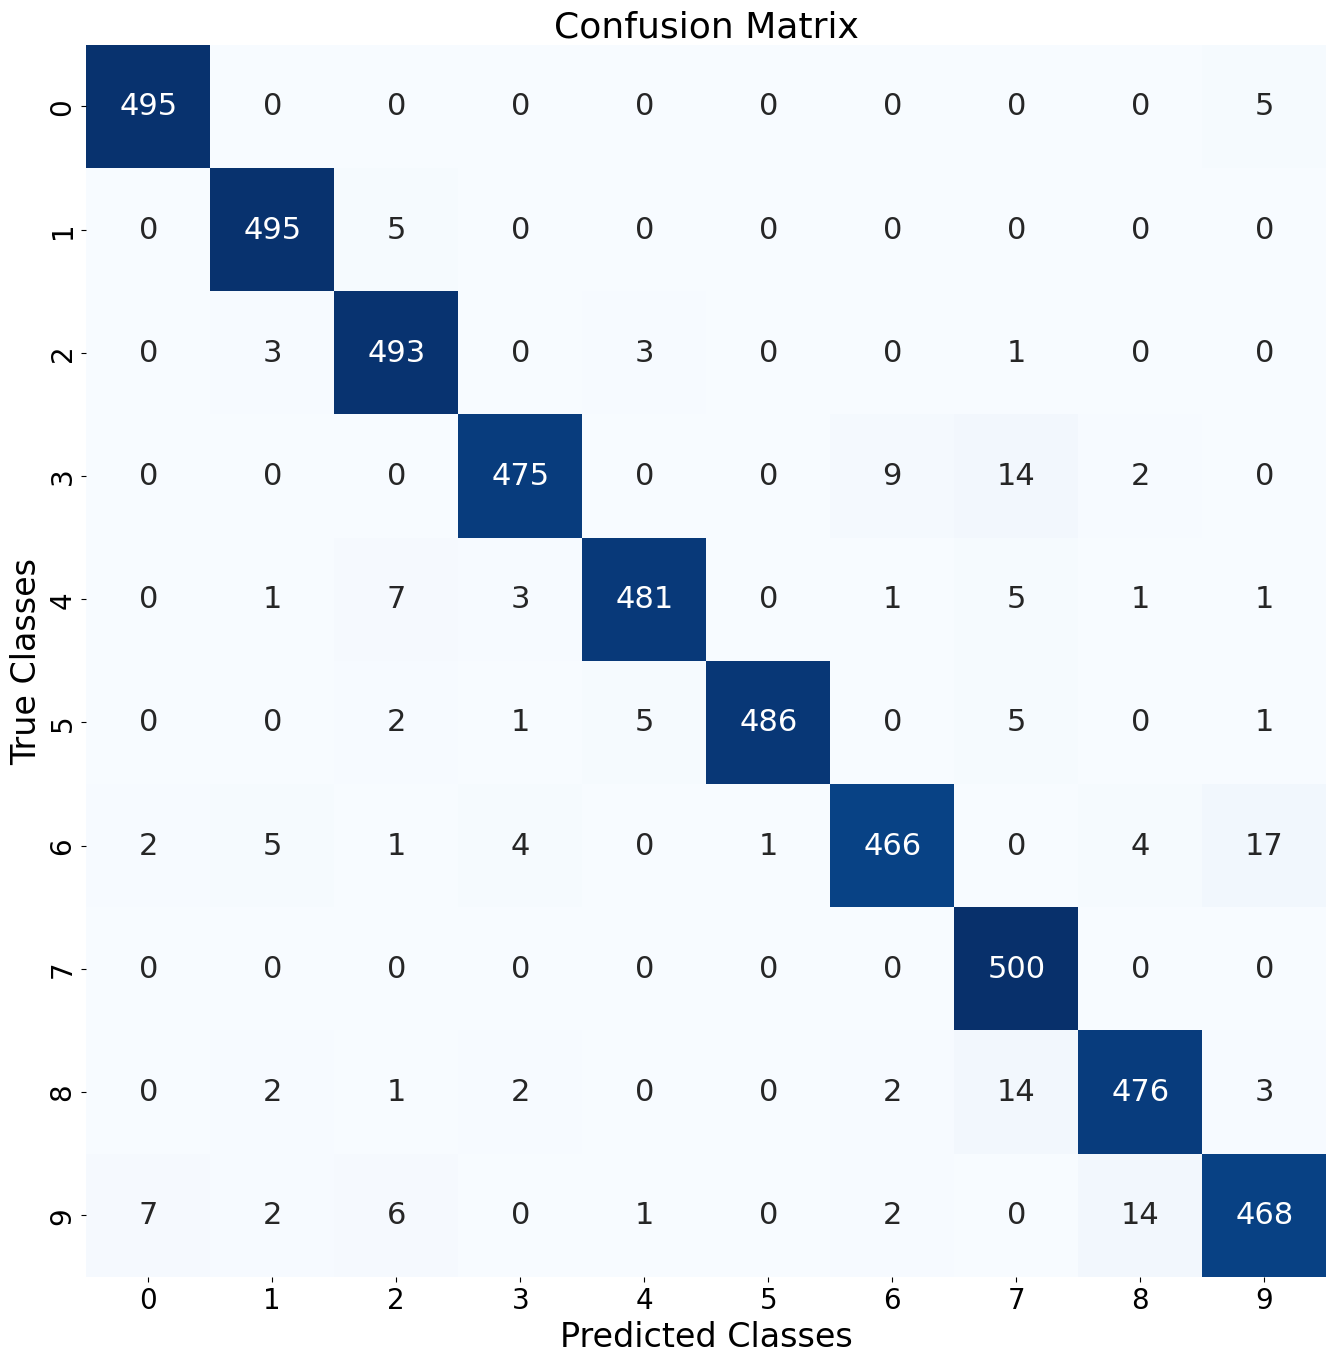

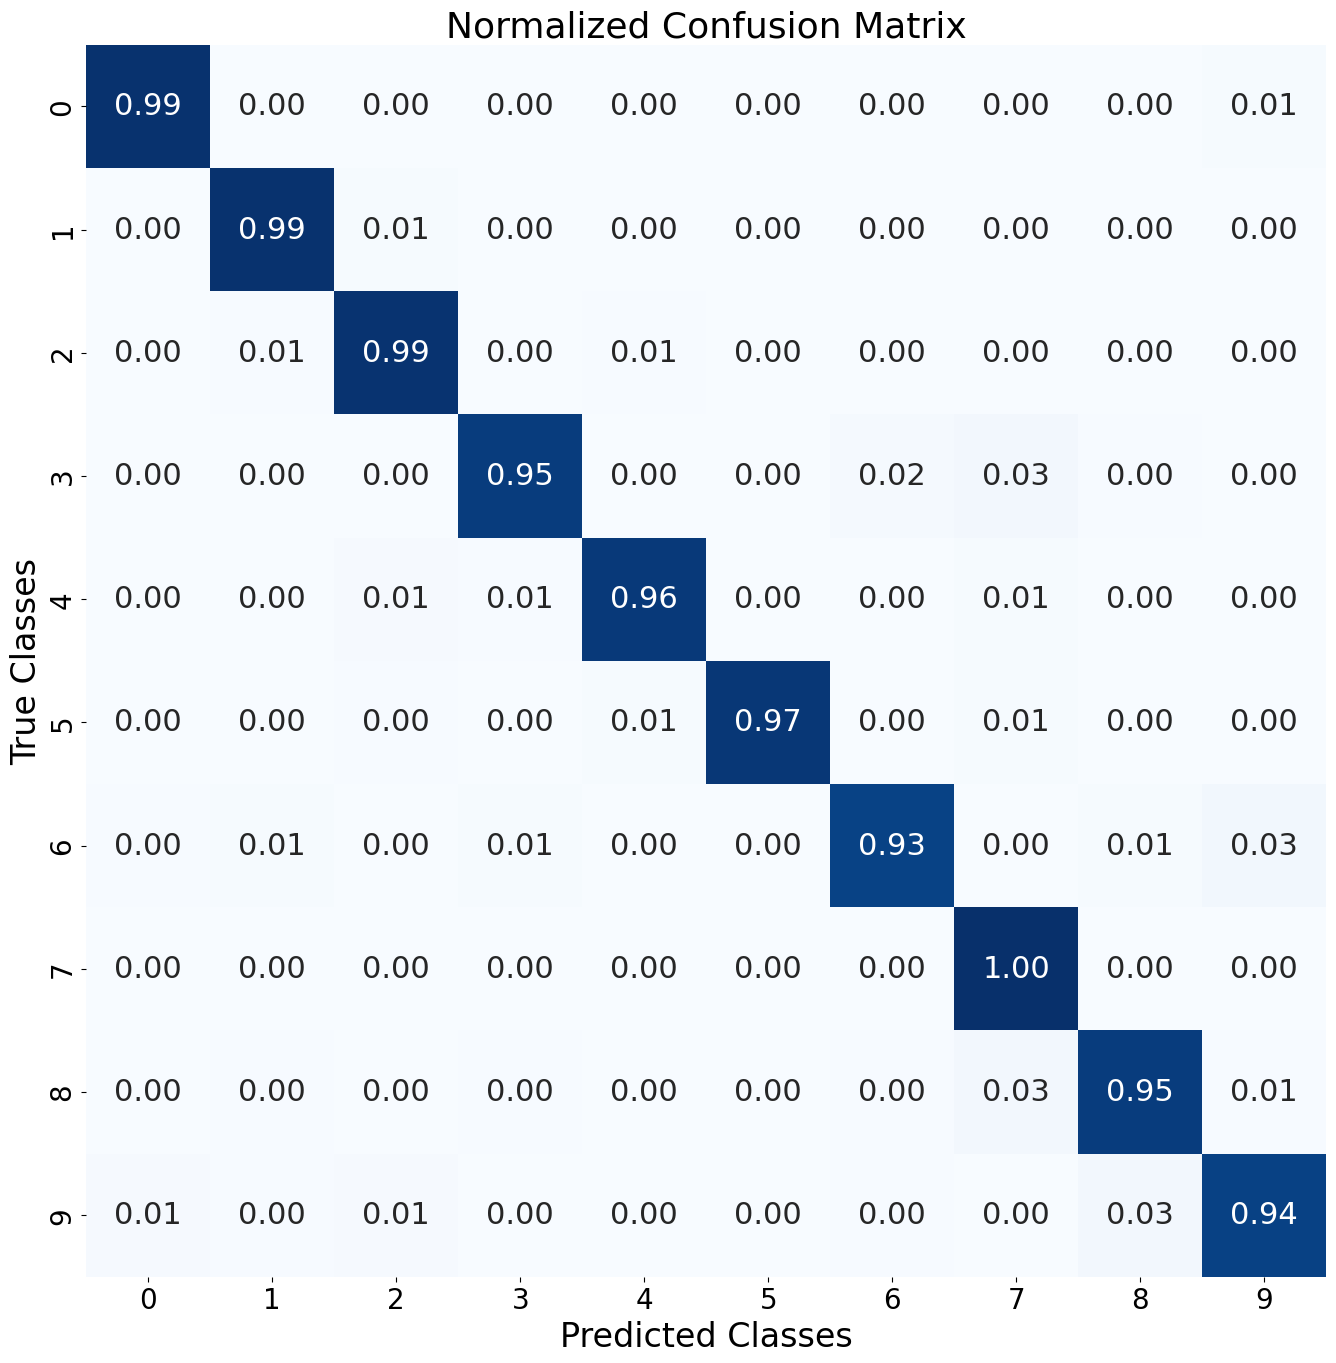

              precision    recall  f1-score   support

           F       0.98      0.99      0.99       500
           G       0.97      0.99      0.98       500
           H       0.96      0.99      0.97       500
           I       0.98      0.95      0.96       500
           J       0.98      0.96      0.97       500
           K       1.00      0.97      0.98       500
           L       0.97      0.93      0.95       500
           M       0.93      1.00      0.96       500
           N       0.96      0.95      0.95       500
           O       0.95      0.94      0.94       500

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000



In [17]:
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, fmt="d", cbar = False, annot_kws={"size": 22},)
plt.title('Confusion Matrix', fontsize=26)
plt.ylabel('True Classes', fontsize=24)
plt.xlabel('Predicted Classes', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

print(classification_report(true_classes, predicted_classes))

# Normalize confusion matrix by row (i.e., by the number of true labels in each class)
normalized_confusionmatrix = confusionmatrix.astype('float') / confusionmatrix.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(16, 16))
sns.heatmap(normalized_confusionmatrix, cmap='Blues', annot=True, fmt=".2f", cbar=False, annot_kws={"size": 22})
plt.title('Normalized Confusion Matrix', fontsize=26)
plt.ylabel('True Classes', fontsize=24)
plt.xlabel('Predicted Classes', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))